Check Python version

In [1]:
!python --version

Python 3.9.16


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Local directory
# data_dir = '../datasets/retail'
# file_name = 'air_passengers'
# file_path = f'{data_dir}/{file_name}.csv'

# Through online GitHub
file_path = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_path)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

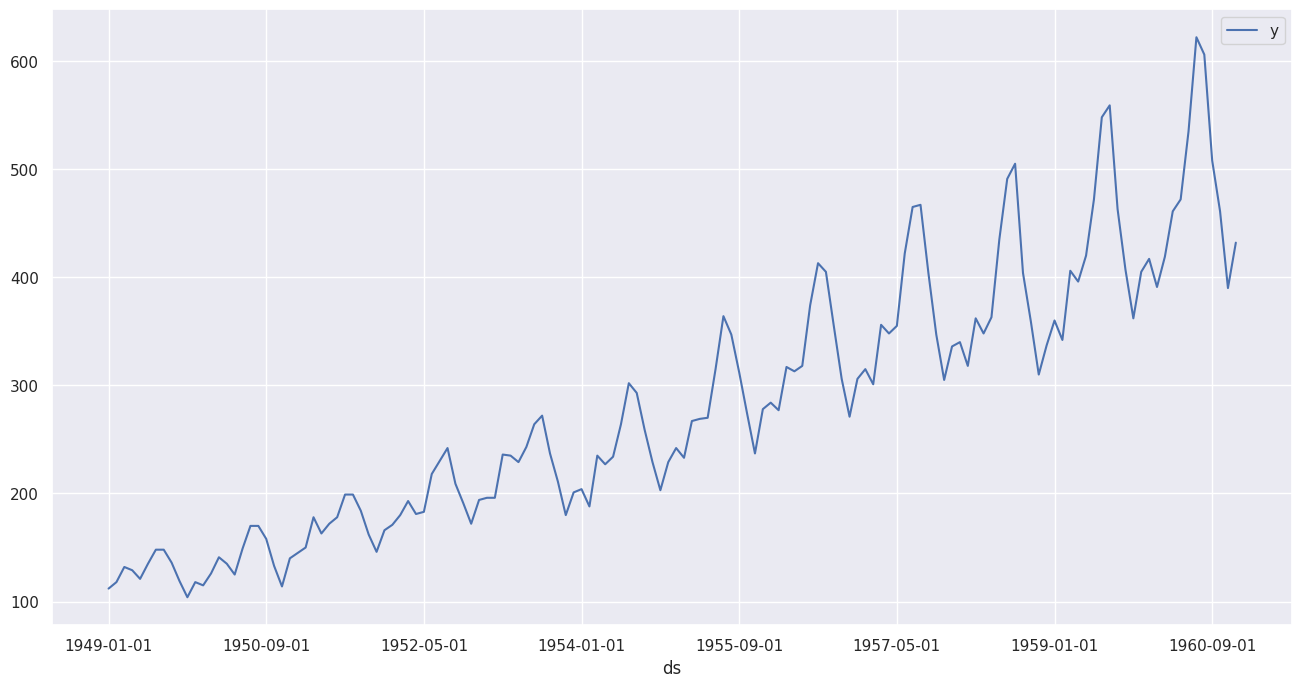

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_autoets'},
            # {'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            {'type': 'stats_autotheta'},
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [20]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: user 6.71 ms, sys: 0 ns, total: 6.71 ms
Wall time: 1.45 s


In [21]:
print(response)
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

<Response [200]>


In [22]:
train_json_out

{'model': 'AgEBCGWnAABgpwAAYIIAABgAAABXggAA7BQAAIAALm1wTWyUc3MMYSlkZHJsYWZ0dHNTlG5pcnMKaZRpjANhcnJhlJRyGHlhjGGTKJRkYXJpbnh0lHJhcmVpbnR4REl9YWEujHVfQpRzcnSMbZOHbXlNlE5KlAGUbS5yZWMHlAFLjJROSpQBlADN19/p8vwFDhghKjQ9R09ZYmx1foiRm6Stt7/J0tzl7vgBCxQdJzA5QkxVX2hxe4SOl6CpsrzFz9jh6/T+BxAZIiw1P0hRW2Rud4CJk5ylr7jBy9Te5/D6AwwWHykyO0VOWGBqc3yGj5miq7W+yNDa4+z2/wkSGyUuOEBKU11mb3mCi5WeqLG6w83W4Ony/AWMTmGUeZRyZZQJbk6FlBhjZWVflGVohShAhwH/S4xolDEoS2KUYnNulHJlc2GTKJRoXGiFKFYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0jC5zZk1phmEFCmgDC3SGgWg1lEuJYlJoBYxiVpSUjJROlEuMlE5KlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQoY2FoeYYLbhN0bmhxTXBjdHRlbmJjZZRyaWmMdG9zZWNleHRhiV9jZW9fY2V4YWGJX2NlaWRkbWyUZZRkZWVuaG9kdHNvYxFpZX1ya

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'predicts': dates
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: user 1.68 ms, sys: 2.45 ms, total: 4.14 ms
Wall time: 17.8 ms


In [28]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [29]:
forecast_json_out

{'data': [['1960-12-31T00:00:00', 410.36128483461886],
  ['1961-01-30T00:00:00', 398.0895065870279],
  ['1961-03-01T00:00:00', 470.87839900216403],
  ['1961-03-31T00:00:00', 457.6103518284629],
  ['1961-04-30T00:00:00', 466.4859174534353],
  ['1961-05-30T00:00:00', 550.2935192769796],
  ['1961-06-29T00:00:00', 619.5298148718002],
  ['1961-07-29T00:00:00', 622.8384255750909],
  ['1961-08-28T00:00:00', 533.3265857733134],
  ['1961-09-27T00:00:00', 455.1033420435147],
  ['1961-10-27T00:00:00', 384.3184546274458],
  ['1961-11-26T00:00:00', 448.2685754960548],
  ['1961-12-26T00:00:00', 458.04522424053],
  ['1962-01-25T00:00:00', 444.37965148599534],
  ['1962-02-24T00:00:00', 523.6508621603512],
  ['1962-03-26T00:00:00', 508.7346672199696],
  ['1962-04-25T00:00:00', 517.8968404024906],
  ['1962-05-25T00:00:00', 608.5878487137622],
  ['1962-06-24T00:00:00', 683.7845940857003],
  ['1962-07-24T00:00:00', 686.7450538055571],
  ['1962-08-23T00:00:00', 588.8817827170994],
  ['1962-09-22T00:00:00',

Combine forecast dates and output

In [30]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [31]:
forecast_df.shape

(24, 2)

In [32]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [33]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,410.361285
1,1961-01-30T00:00:00,398.089507
2,1961-03-01T00:00:00,470.878399
3,1961-03-31T00:00:00,457.610352
4,1961-04-30T00:00:00,466.485917


In [34]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,686.745054
20,1962-08-23T00:00:00,588.881783
21,1962-09-22T00:00:00,503.390700
22,1962-10-22T00:00:00,426.289088
23,1962-11-21T00:00:00,495.354522


Plot train and forecast side-by-side

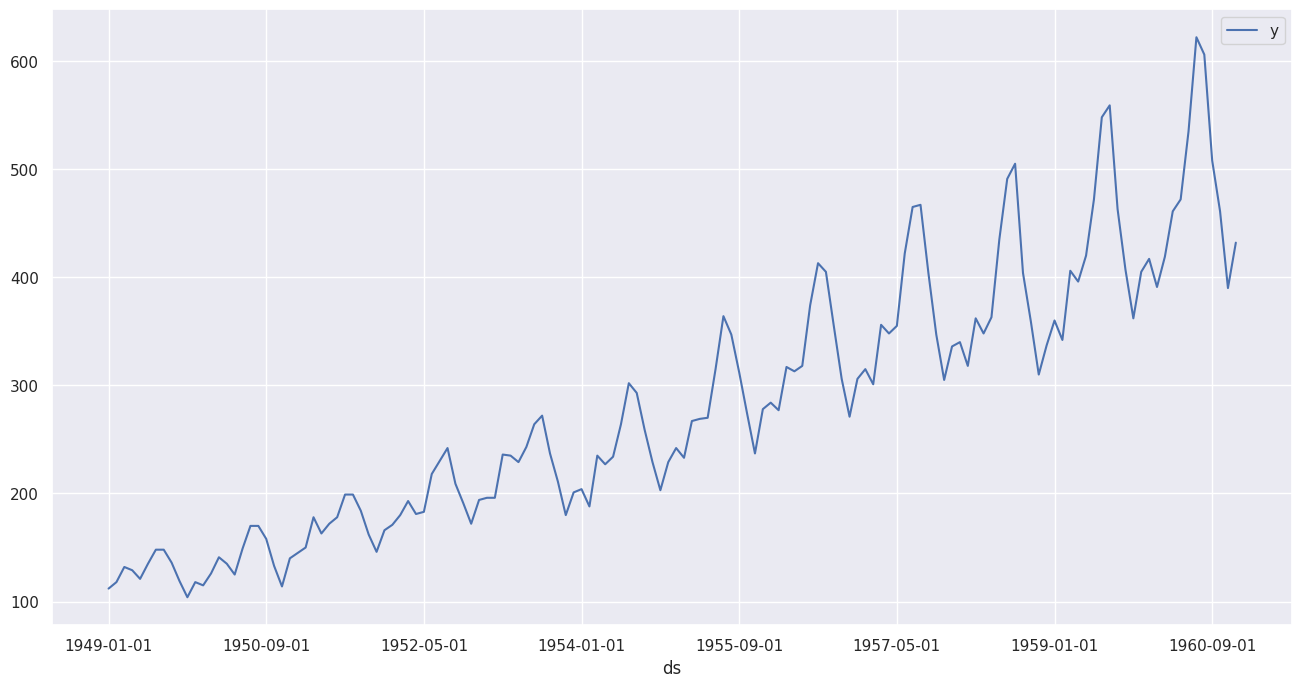

In [35]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

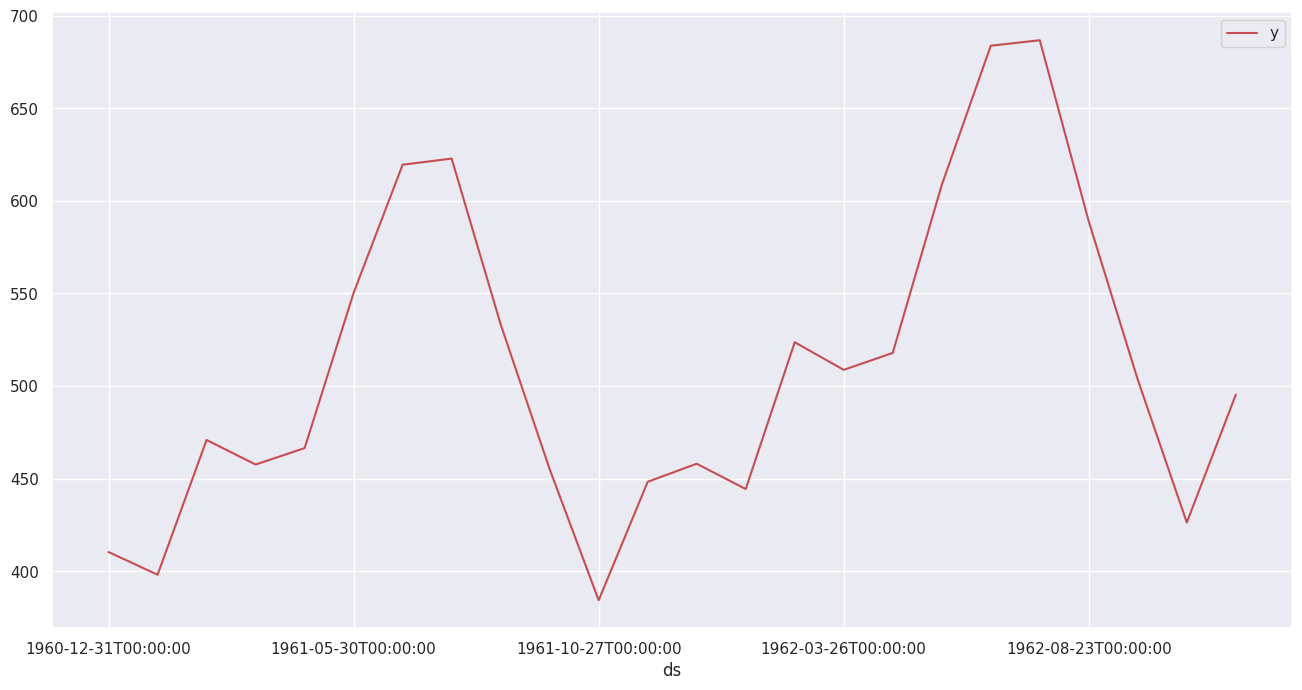

In [36]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [37]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [38]:
df.shape

(168, 3)

In [39]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [40]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,686.745054,r
164,1962-08-23T00:00:00,588.881783,r
165,1962-09-22T00:00:00,503.390700,r
166,1962-10-22T00:00:00,426.289088,r
167,1962-11-21T00:00:00,495.354522,r


Plot combined train and test sets with the vertical black line as the cut-off

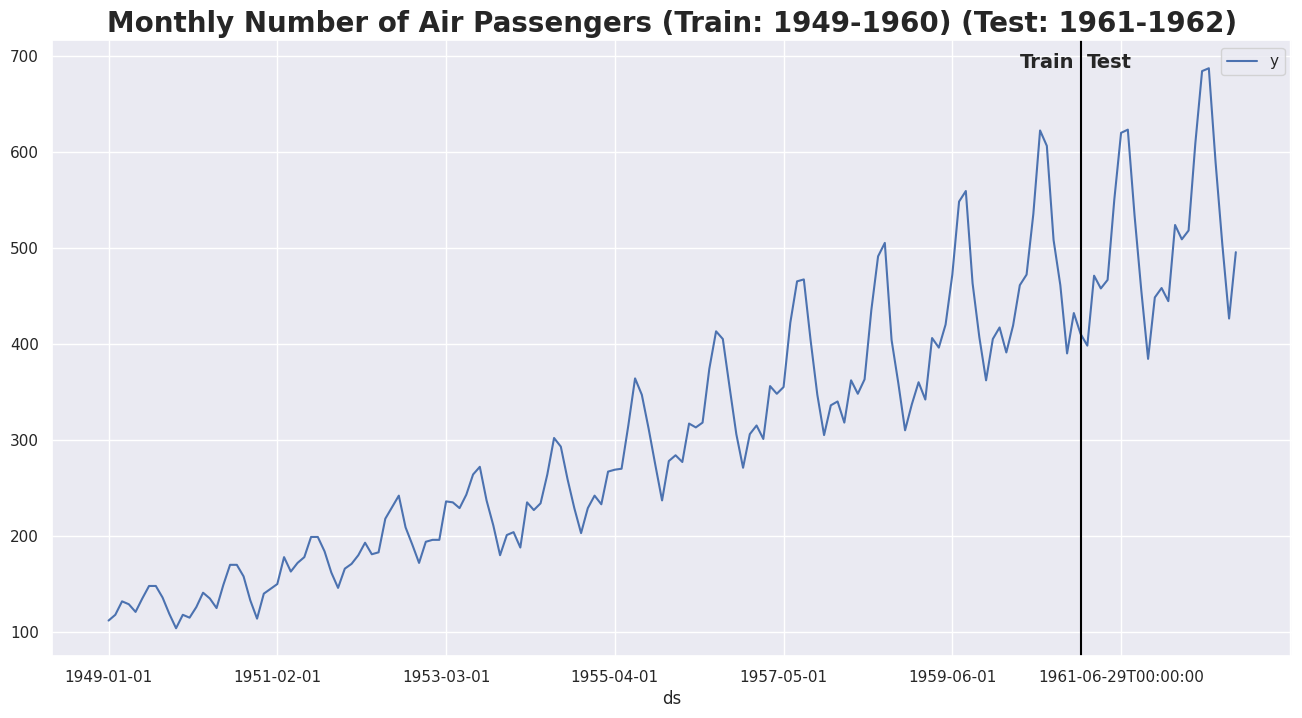

In [41]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();